# <오늘 할 것: KoNLPy, W2V, RNN>

# 1. 감정분류 (imdb)
- 1-1. 데이터 로드하기
- 1-2. EDA
- 1-3. 디코딩하기
- 1-4. 빈도분석하기
- 1-5. 분류하기(SVM)
- 1-6. TF-IDF로 다시 해보기

# 2. 형태소 분석하기
- 2-1. Konlpy 사전 설정하기(Java)
- 2-2. Okt
- 2-3. Kkma

# 3. Word Embedding: Word2Vec
- 3-1. 네이버 영화 리뷰 예제
    - 3-1-1. 데이터 로드하기
    - 3-1-2. 형태소 분석하기
    - 3-1-3. w2v 모델링
- 3-2. TSNE 활용해서 차원축소/시각화하기

## 부록) PCA 개념잡기

# 4. RNN

# 1. 감정분류 (imdb) 

In [1]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.datasets import imdb
from konlpy.tag import Twitter
from konlpy.tag import Okt
from konlpy.tag import Kkma 
from konlpy.tag import Twitter
from pprint import pprint
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
from wordcloud import WordCloud, STOPWORDS
from gensim import corpora, models
import numpy  as np
from PIL import Image
from wordcloud import ImageColorGenerator
import glob
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

## 1-1. 데이터 로드하기

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)  # 단어 빈도수 상위 10000개 사용
# 영화 리뷰는 X_train에, 감성 정보는 y_train에 저장된다.
# 테스트용 리뷰는 X_test에, 테스트용 리뷰의 감성 정보는 y_test에 저장된다.
#위에서 num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지를 사용할 것인지 조절하는 것입니다. 예를 들어서 10,000이란 값을 넣으면, 등장 빈도 순위가 1~10,000에 해당하는 단어만 사용하게 됩니다. 즉, 단어의 종류는 10,000개가 되므로 단어 집합의 크기는 10,000이 됩니다.

17465344/17464789 [==============================] - 1s 0us/step


## 1-2. EDA

In [5]:
print(X_train[0])
print(X_train[1])

print(len(X_train[0]))
print(len(X_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 1

- 첫번째와 두번째 데이터의 크기가 다르다.
- 불용어와 빈도수가 너무 낮은 단어들은 빠졌다.
- 데이터를 있는 그대로 디코딩하기는 힘들다.

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


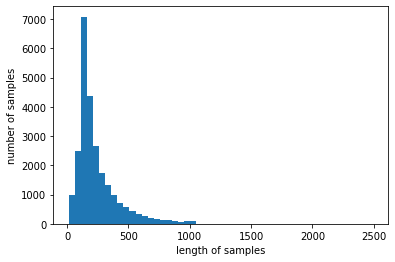

In [6]:
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 1-3. 디코딩하기

In [7]:
word_to_index = imdb.get_word_index()    # 없으면 다운로드함

index_to_word={}       #키와 밸류를 바꿈
for key, value in word_to_index.items():
    index_to_word[value] = key

1646592/1641221 [==============================] - 0s 0us/step


In [8]:
word_to_index   #단어와 인덱스를 매칭한 딕셔너리

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [9]:
index_to_word       #인덱스와 단어를 매칭한 딕셔너리

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

In [10]:
index_to_word[1]

'the'

In [11]:
index_to_word[14]

'as'

In [12]:
#0번째 데이터 디코딩
print(' '.join([index_to_word[X] for X in X_train[0]]))

the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have tw

In [18]:
#전체 데이터 디코딩
X_train_s = [' '.join([index_to_word[X] for X in X_train[i]]) for i in range(len(X_train))]
X_test_s = [' '.join([index_to_word[X] for X in X_test[i]]) for i in range(len(X_test))]

In [19]:
X_train_s[600]

"the places and social i i was one life is seriously br highly views fact many should movie of and of jane did subsequently escapes to criminals disc \x96 was supposed strange light of directed end his form first as unlikely or sex in gang of you it cockney film walter love and or is time death guy moment see knew such of violence happen between finally should movie even then through some more then through some more vanessa also have what would role have vanessa car have to what would language have poor performances it br on son i i as you landscape time over being quickly to in at shooting was against laugh read has when giant to jr with irs moving any movie from he out is save br and weren't decent like ever family even scientist and an from people it critics to and unfortunately of problem on to what of decent tells passing were romeo no from people and of insights he used funniest has catches jane it's don't by br of decent help with cute and football mildred no poor never stinks w

## 1-4. 빈도분석하기

In [20]:
count_vect = CountVectorizer(analyzer = 'word')
count_vect.fit(X_train_s + X_test_s)   #학습 + 테스트 섞어서 단어 벡터 만들기

xtrain_count = count_vect.transform(X_train_s)
xtest_count = count_vect.transform(X_test_s)

In [24]:
print(xtrain_count.shape)
print(xtest_count.shape)

(25000, 9774)
(25000, 9774)


- 25000개 샘플
- 9774 차원(전체 vocabulary가 9774개)

In [25]:
print(len(X_train[0]))

218


벡터화 이전 0번째 데이터는 218차원

=> 벡터화 후 9774차원

#### 엄청나게 sparse 한 matrix임을 알 수 있다.

In [26]:
print(xtrain_count[0])

  (0, 138)	1
  (0, 224)	1
  (0, 312)	1
  (0, 456)	3
  (0, 463)	6
  (0, 523)	1
  (0, 527)	2
  (0, 597)	1
  (0, 632)	3
  (0, 676)	1
  (0, 681)	1
  (0, 829)	1
  (0, 893)	1
  (0, 1005)	1
  (0, 1069)	1
  (0, 1151)	2
  (0, 1299)	3
  (0, 1340)	1
  (0, 1529)	1
  (0, 1580)	1
  (0, 2171)	1
  (0, 2220)	1
  (0, 2668)	1
  (0, 3021)	1
  (0, 3114)	2
  :	:
  (0, 8766)	1
  (0, 8772)	2
  (0, 8779)	3
  (0, 8780)	1
  (0, 8792)	2
  (0, 8816)	1
  (0, 8889)	9
  (0, 9094)	2
  (0, 9173)	1
  (0, 9318)	1
  (0, 9382)	1
  (0, 9442)	1
  (0, 9466)	3
  (0, 9470)	1
  (0, 9475)	1
  (0, 9544)	1
  (0, 9550)	2
  (0, 9555)	1
  (0, 9557)	1
  (0, 9575)	1
  (0, 9593)	1
  (0, 9633)	11
  (0, 9655)	1
  (0, 9732)	1
  (0, 9744)	6


## 1-5. 분류하기(SVM)

In [30]:
model = LinearSVC()
model.fit(xtrain_count, y_train)    # y_train은 바이너리로 되어 있다.(긍정 1, 부정 0)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [33]:
y_pred = model.predict(xtest_count)
print(len(y_pred))
print(y_pred)
sum((y_test == y_pred)*1) / 25000

25000
[0 1 1 ... 0 0 1]


0.83024

인식률이 꽤 괜찮다.

In [43]:
text = "good story"
text_count = count_vect.transform([text])

y_pred = model.predict(text_count)

In [44]:
y_pred

array([0], dtype=int64)

"good story"를 부정으로 평가한다. 성능이 썩 좋지는 않다.

### 1-6. TF-IDF로 다시 해보기

In [46]:
#벡터화
tfidf_vect = TfidfVectorizer(analyzer = 'word')
tfidf_vect.fit(X_train_s + X_test_s)

xtrain_tfidf_count = tfidf_vect.transform(X_train_s)
xtest_tfidf_count = tfidf_vect.transform(X_test_s)

#분류하기
model = LinearSVC()
model.fit(xtrain_tfidf_count, y_train)

y_pred_tfidf = model.predict(xtest_tfidf_count)
print(len(y_pred_tfidf))
print(y_pred_tfidf)
sum((y_test == y_pred_tfidf)*1) / 25000

25000
[0 1 1 ... 0 0 1]


0.87456

인식률이 꽤 개선되었다.

In [53]:
text = "good story"
text_count = tfidf_vect.transform([text])

y_pred = model.predict(text_count)

In [54]:
y_pred

array([0], dtype=int64)

근데 이것도 딱히 정확하지는 않다.

좀 더 긴 텍스트를 넣어본다.

In [ ]:
text = "good story"
text_count = tfidf_vect.transform([text])

y_pred = model.predict(text_count)

y_pred

# 2. 형태소 분석하기

## 2-1. Konlpy 사전 설정하기(Java)

1. Jpype1 설치
https://www.lfd.uci.edu/~gohlke/pythonlibs/#jpype

`pip uninstall jpype1`

`pip install JPype1-0.7.1-cp37-cp37m-win_amd64.whl`


2. Java 설치
https://github.com/ojdkbuild/ojdkbuild


3. Java 환경변수 설정

내컴퓨터 > 속성 > 고급 시스템 설정

환경변수 > 시스템 변수 새로만들기
- 변수 이름: `JAVA_HOME`
- 변수 값: `C:\Program Files\ojdkbuild\java-1.8.0-openjdk-1.8.0.242-1` (openjdk가 설치된 경로)



## 2-2. Okt

In [49]:
from konlpy.tag import Okt
okt = Okt()

`pos` 메소드로 품사를 태깅할 수 있다.
- `okt.pos(텍스트, norm=True, stem=True)`
    - norm: 정규화를 할 것인지(??)
    - stem: 단어를 원형으로 바꿀 것인지

In [50]:
okt = Okt()
malist = okt.pos("아버지 가방에 들어가신다.", norm=True, stem=True) 
print(malist)

[('아버지', 'Noun'), ('가방', 'Noun'), ('에', 'Josa'), ('들어가다', 'Verb'), ('.', 'Punctuation')]


In [55]:
print(okt.nouns(u'을지로 3가역 주변 점단빌딩숲 사이에 자리 잡은 커피집'))
print(okt.pos(u'이것도 되나요ㅋㅋ'))
print(okt.pos(u'이것도 되나요ㅋㅋ', norm=True, stem=True))

['을지로', '역', '주변', '점', '빌딩', '숲', '사이', '자리', '커피집']
[('이', 'Determiner'), ('것', 'Noun'), ('도', 'Josa'), ('되나요', 'Verb'), ('ㅋㅋ', 'KoreanParticle')]
[('이', 'Determiner'), ('것', 'Noun'), ('도', 'Josa'), ('되다', 'Verb'), ('ㅋㅋ', 'KoreanParticle')]


## 2-3. kkma

In [56]:
from konlpy.tag import Kkma
kkma = Kkma()

#문장분리
print('kkma 문장분리: ', kkma.sentences('안녕하세요. 반갑습니다. 저는 인공지능입니다.'))

#명사추출
print('kkma 명사추출: ', kkma.nouns('을지로 3가역 주변 점단빌딩숲 사이에 자리 잡은 커피집'))

kkma 문장분리:  ['안녕하세요.', '반갑습니다.', '저는 인공지능입니다.']
kkma 명사추출:  ['을지', '3', '역', '주변', '점단', '점단빌딩숲', '빌딩', '숲', '사이', '자리', '커피', '커피집', '집']


# 3. Word Embedding: Word2Vec

- Continuous Bag of Words
> 주변에 있는 단어(context word)들을 가지고, 중간에 있는 단어(center word)들을 예측하는 방법


#### 1. 모델 생성

`Word2Vec(데이터, size, window, min_count)`
   
   - 데이터: 단어들의 리스트(문서단위)의 리스트
   - size: 벡터화 차원
   - window: 양옆으로 몇개 단어를 볼지
   - min_count: 최소 출현 빈도

#### 2. 단어 벡터

`모델.wv`
   - `.vocab`: 전체 vocabulary를 딕셔너리로 리턴한다.
        - 단어: 어떤 값 쌍으로 이루어짐
   - `.similarity`: 두 단어 간 코사인 유사도를 리턴한다.
        - `모델.wv.similarity(단어1, 단어2)`
        - 리턴값은 -1에서 1 사이에 분포한다.
   - `.most_similar`: 특정 단어와 유사한 단어들을 리스트로 리턴한다.
        - `모델.wv.most_similar(단어, topn)`
            - topn: 유의어를 몇개 볼지

In [57]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import codecs
from konlpy.tag import Twitter
from gensim.models import word2vec
from konlpy.utils import pprint
from sklearn.manifold import TSNE

In [65]:
sentences = [
                ['this', 'is', 'a',   'good',      'product'],
                ['it',   'is', 'a',   'excellent', 'product'],
                ['it',   'is', 'a',   'bad',       'product'],
                ['that', 'is', 'the', 'worst',     'product']
            ]

# 문장을 이용하여 단어와 벡터를 생성한다.
model = Word2Vec(sentences, size=20, window=3, min_count=1)

# 단어벡터를 구한다.
word_vectors = model.wv

In [77]:
word_vectors

In [67]:
print(word_vectors["this"])
print(word_vectors["the"])

[-0.00658768 -0.01597179  0.02008077  0.01163127  0.02205923  0.00723635
  0.0084954   0.00545747  0.00550438  0.02275979  0.0040604  -0.01694023
 -0.02269066 -0.01898951  0.01744254 -0.00141948 -0.01858043  0.00349182
  0.02085456  0.01475909]
[-0.00581518  0.00761503  0.02433336  0.00950113  0.01368304 -0.00431652
  0.02473336  0.02048244 -0.01542627  0.00252594  0.02025281 -0.01917338
  0.01070372 -0.00782784 -0.00386423 -0.02158185  0.00343993 -0.00649094
 -0.01138344 -0.00060776]


In [60]:
word_vectors.most_similar('this')

[('that', 0.5868227481842041),
 ('bad', 0.518202543258667),
 ('the', 0.24466852843761444),
 ('is', 0.10481591522693634),
 ('product', -0.059957876801490784),
 ('excellent', -0.13807088136672974),
 ('worst', -0.1599997580051422),
 ('a', -0.1815032660961151),
 ('good', -0.3785679042339325),
 ('it', -0.37979668378829956)]

In [145]:
word_vectors.vocab

{'this': <gensim.models.keyedvectors.Vocab at 0x1ed12cc71c8>,
 'is': <gensim.models.keyedvectors.Vocab at 0x1ed12cc7248>,
 'a': <gensim.models.keyedvectors.Vocab at 0x1ed12cc72c8>,
 'good': <gensim.models.keyedvectors.Vocab at 0x1ed12cc7348>,
 'product': <gensim.models.keyedvectors.Vocab at 0x1ed12cc7448>,
 'it': <gensim.models.keyedvectors.Vocab at 0x1ed12cc7508>,
 'excellent': <gensim.models.keyedvectors.Vocab at 0x1ed12cc7548>,
 'bad': <gensim.models.keyedvectors.Vocab at 0x1ed12cc7588>,
 'that': <gensim.models.keyedvectors.Vocab at 0x1ed12cc7388>,
 'the': <gensim.models.keyedvectors.Vocab at 0x1ed12cc7488>,
 'worst': <gensim.models.keyedvectors.Vocab at 0x1ed12cc7608>}

In [68]:
vocabs = word_vectors.vocab.keys()
print(vocabs)

dict_keys(['this', 'is', 'a', 'good', 'product', 'it', 'excellent', 'bad', 'that', 'the', 'worst'])


In [69]:
word_vectors_list = [word_vectors[v] for v in vocabs]
print(word_vectors_list)

[array([-0.00658768, -0.01597179,  0.02008077,  0.01163127,  0.02205923,
        0.00723635,  0.0084954 ,  0.00545747,  0.00550438,  0.02275979,
        0.0040604 , -0.01694023, -0.02269066, -0.01898951,  0.01744254,
       -0.00141948, -0.01858043,  0.00349182,  0.02085456,  0.01475909],
      dtype=float32), array([ 0.01454965,  0.0222459 , -0.02006236,  0.01801295,  0.02053034,
        0.01743255,  0.01403649, -0.01483791, -0.00963206,  0.02359637,
       -0.01188717,  0.00645598, -0.01545938, -0.00920401, -0.01584862,
        0.01045146, -0.02191257, -0.02003548, -0.00315351, -0.019552  ],
      dtype=float32), array([-0.01423625, -0.00467639, -0.00363447, -0.02242661,  0.00744561,
       -0.01867504, -0.02297657,  0.02327053, -0.02393838, -0.00090982,
       -0.02180841, -0.00107927,  0.01527025,  0.00733357,  0.00182316,
        0.00407002,  0.01701709,  0.01742056,  0.00509289,  0.01520817],
      dtype=float32), array([-0.02239665, -0.00340193, -0.0208302 , -0.00966239, -0.0122

In [76]:
print(model.wv.similarity(w1='it', w2='the'))

-0.18840605


In [73]:
model.wv.most_similar('it')

[('a', 0.24966639280319214),
 ('good', 0.17662103474140167),
 ('worst', 0.0012963376939296722),
 ('bad', -0.024029351770877838),
 ('excellent', -0.041416049003601074),
 ('product', -0.07349294424057007),
 ('that', -0.1470155566930771),
 ('is', -0.16448821127414703),
 ('the', -0.1884060651063919),
 ('this', -0.37979668378829956)]

## 3-1. 네이버 영화 리뷰 예제

### 3-1-1. 데이터 로드하기

In [78]:
#파일 읽기 함수. 첫줄 헤더를 제외하고 한 줄씩 읽어서 data 에 담아서 리턴 한다.
def read_data(filename):
    with open(filename, encoding='utf-8', mode='r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
    return data

ratings_train = read_data('ratings_train.txt')

In [79]:
print(ratings_train[0])

['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0']


### 3-1-2. 형태소 분석하기

In [80]:
okt = Okt()

def tokens(doc):
    return ['/'.join(t) for t in okt.pos(doc, norm = True, stem = True)]

In [81]:
docs = []
for row in ratings_train:
    docs.append(row[1])

data = [tokens(d) for d in docs]

In [82]:
data

[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 ['흠/Noun',
  '.../Punctuation',
  '포스터/Noun',
  '보고/Noun',
  '초딩/Noun',
  '영화/Noun',
  '줄/Noun',
  '..../Punctuation',
  '오버/Noun',
  '연기/Noun',
  '조차/Josa',
  '가볍다/Adjective',
  '않다/Verb'],
 ['너/Modifier',
  '무재/Noun',
  '밓었/Noun',
  '다그/Noun',
  '래서/Noun',
  '보다/Verb',
  '추천/Noun',
  '한/Josa',
  '다/Adverb'],
 ['교도소/Noun',
  '이야기/Noun',
  '구먼/Noun',
  '../Punctuation',
  '솔직하다/Adjective',
  '재미/Noun',
  '는/Josa',
  '없다/Adjective',
  '../Punctuation',
  '평점/Noun',
  '조정/Noun'],
 ['사이/Modifier',
  '몬페/Noun',
  '그/Determiner',
  '의/Noun',
  '익살스럽다/Adjective',
  '연기/Noun',
  '가/Josa',
  '돋보이다/Verb',
  '영화/Noun',
  '!/Punctuation',
  '스파이더맨/Noun',
  '에서/Josa',
  '늙다/Verb',
  '보이다/Verb',
  '하다/Verb',
  '커스틴/Noun',
  '던스트/Noun',
  '가/Josa',
  '너무나도/Adverb',
  '이쁘다/Adjective',
  '보이다/Verb'],
 ['막/Noun',
  '걸음/Noun',
  '마/Noun',
  '떼다/Verb',
  '3/Number',
  '세/Noun',
  '부터/Josa',
  '초등학교/Noun',

### 3-1-3. w2v 모델링

In [94]:
w2v_model = word2vec.Word2Vec(data, size=100, window=3, min_count=2)

In [95]:
w2v_model.save('naver.model')

In [96]:
vocabs = w2v_model.wv.vocab.keys()
print(vocabs)

dict_keys(['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증나다/Adjective', '목소리/Noun', '흠/Noun', '.../Punctuation', '포스터/Noun', '보고/Noun', '초딩/Noun', '영화/Noun', '줄/Noun', '..../Punctuation', '오버/Noun', '연기/Noun', '조차/Josa', '가볍다/Adjective', '않다/Verb', '너/Modifier', '무재/Noun', '다그/Noun', '래서/Noun', '보다/Verb', '추천/Noun', '한/Josa', '다/Adverb', '교도소/Noun', '이야기/Noun', '구먼/Noun', '솔직하다/Adjective', '재미/Noun', '는/Josa', '없다/Adjective', '평점/Noun', '조정/Noun', '사이/Modifier', '몬페/Noun', '그/Determiner', '의/Noun', '익살스럽다/Adjective', '가/Josa', '돋보이다/Verb', '!/Punctuation', '스파이더맨/Noun', '에서/Josa', '늙다/Verb', '보이다/Verb', '하다/Verb', '커스틴/Noun', '던스트/Noun', '너무나도/Adverb', '이쁘다/Adjective', '막/Noun', '걸음/Noun', '마/Noun', '떼다/Verb', '3/Number', '세/Noun', '부터/Josa', '초등학교/Noun', '1/Number', '학년/Noun', '생인/Noun', '8/Number', '살다/Verb', './Punctuation', 'ㅋㅋㅋ/KoreanParticle', '별/Modifier', '반개/Noun', '도/Josa', '아깝다/Adjective', '움/Noun', '원작/Noun', '의/Josa', '긴장감/Noun', '을/Josa', '제대로/Noun', '살리다/Ve

In [98]:
print(w2v_model.wv.most_similar(positive=tokens(u'남자 여배우'),   
        negative=tokens(u'배우'), topn=1))    #'남자' + '여배우' - '배우'의 결과를 리턴한다. ==> '여자'

[('여자/Noun', 0.83765709400177)]


모델을 만들 때 **'단어/품사'** 형태로 넣어줘서 vocab도 같은 형식으로 되어 있음;

따라서 대부분의 메소드를 활용할 때 같은 형식을 맞춰서 인자를 넘겨야 한다.

=>그래서 '단어'가 아니라 tokens('단어') 형태로 전달하는 것임

In [97]:
w2v_model.wv.most_similar(tokens('정우성'))

[('패닝/Noun', 0.8912063837051392),
 ('신민아/Noun', 0.8782227039337158),
 ('전도연/Noun', 0.877834677696228),
 ('송일국/Noun', 0.877021312713623),
 ('임수정/Noun', 0.875443160533905),
 ('장혁/Noun', 0.8741878867149353),
 ('김하늘/Noun', 0.8741074204444885),
 ('박신양/Noun', 0.872927725315094),
 ('공효진/Noun', 0.8723848462104797),
 ('엄태웅/Noun', 0.8721791505813599)]

In [99]:
w2v_model.wv.most_similar(tokens('약하다'))

[('부족하다/Adjective', 0.7989590764045715),
 ('부실하다/Adjective', 0.7985092997550964),
 ('부자연스럽다/Adjective', 0.7965178489685059),
 ('산만하다/Adjective', 0.7964551448822021),
 ('억지스럽다/Adjective', 0.7863600254058838),
 ('어둡다/Adjective', 0.7782780528068542),
 ('밋밋하다/Adjective', 0.777671217918396),
 ('촌스럽다/Adjective', 0.7620419263839722),
 ('빈약하다/Adjective', 0.7590265870094299),
 ('특이하다/Adjective', 0.7579895257949829)]

In [ ]:
vocabs = w2v_model.wv.vocab.keys()

In [101]:
w2v_model.wv.most_similar(tokens('재밌다'))

[('재미있다/Adjective', 0.9524615406990051),
 ('재다/Verb', 0.916884183883667),
 ('괜찮다/Adjective', 0.6714385747909546),
 ('웃기다/Verb', 0.6190657615661621),
 ('실망하다/Adjective', 0.6159638166427612),
 ('멋있다/Adjective', 0.6063929200172424),
 ('꿀잼/Noun', 0.5906363129615784),
 ('오래되다/Adjective', 0.5832548141479492),
 ('귀엽다/Adjective', 0.5755757093429565),
 ('무섭다/Adjective', 0.5661802291870117)]

## 3-2. t-SNE를 활용해서 차원축소/시각화하기
> Stochastic Neighbor Embedding

> t 분포 확률적 임베딩

- 데이터 간의 거리를 stochastic probability로 변환하여 효과적으로 차원축소를 실행한다.
    - 차원축소를 효과적으로 실행한다는 것은?:
        - 고차원에서 서로 이웃으로 분류되는 두 데이터가 저차원에서도 똑같이 이웃으로 뽑히도록 하는 것.
        - 거리 보존
        
- 그리고 이걸 2차원 공간에 맵핑한 결과를 시각화하는 툴도 포함하고 있다.

In [112]:
vocab = list(w2v_model.wv.vocab)
print(vocab)

['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증나다/Adjective', '목소리/Noun', '흠/Noun', '.../Punctuation', '포스터/Noun', '보고/Noun', '초딩/Noun', '영화/Noun', '줄/Noun', '..../Punctuation', '오버/Noun', '연기/Noun', '조차/Josa', '가볍다/Adjective', '않다/Verb', '너/Modifier', '무재/Noun', '다그/Noun', '래서/Noun', '보다/Verb', '추천/Noun', '한/Josa', '다/Adverb', '교도소/Noun', '이야기/Noun', '구먼/Noun', '솔직하다/Adjective', '재미/Noun', '는/Josa', '없다/Adjective', '평점/Noun', '조정/Noun', '사이/Modifier', '몬페/Noun', '그/Determiner', '의/Noun', '익살스럽다/Adjective', '가/Josa', '돋보이다/Verb', '!/Punctuation', '스파이더맨/Noun', '에서/Josa', '늙다/Verb', '보이다/Verb', '하다/Verb', '커스틴/Noun', '던스트/Noun', '너무나도/Adverb', '이쁘다/Adjective', '막/Noun', '걸음/Noun', '마/Noun', '떼다/Verb', '3/Number', '세/Noun', '부터/Josa', '초등학교/Noun', '1/Number', '학년/Noun', '생인/Noun', '8/Number', '살다/Verb', './Punctuation', 'ㅋㅋㅋ/KoreanParticle', '별/Modifier', '반개/Noun', '도/Josa', '아깝다/Adjective', '움/Noun', '원작/Noun', '의/Josa', '긴장감/Noun', '을/Josa', '제대로/Noun', '살리다/Verb', '별/No

In [113]:
X = w2v_model[vocab]
print(X.shape)
print(X)

(27477, 100)
[[-6.3455987e-01 -1.5055106e+00  1.0653177e+00 ...  1.7959718e-01
   3.8877240e-01 -5.9164685e-01]
 [-1.1328619e+00 -1.1637967e+00  8.3147120e-01 ...  3.1084567e-01
  -1.0366000e+00  4.6254158e-01]
 [ 7.9775852e-01 -2.6809475e-01  1.7732240e+00 ...  3.3347759e-01
  -4.8262465e-01  3.8370484e-01]
 ...
 [-4.4117603e-03 -2.1632468e-02  1.1533710e-02 ...  4.3445709e-03
   4.8484220e-03 -6.1564324e-03]
 [ 6.1408635e-03  4.6756607e-03  9.0005798e-03 ... -1.5475465e-02
  -2.8135827e-02  5.1911087e-03]
 [ 4.8966444e-04 -2.3644986e-02 -3.0493038e-02 ...  2.5105868e-02
  -7.2846147e-03  1.8519266e-02]]


C:\Users\student\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [132]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X[:100,:])

In [133]:
X_tsne.shape

(100, 2)

100차원에서 2차원으로 축소되었다.

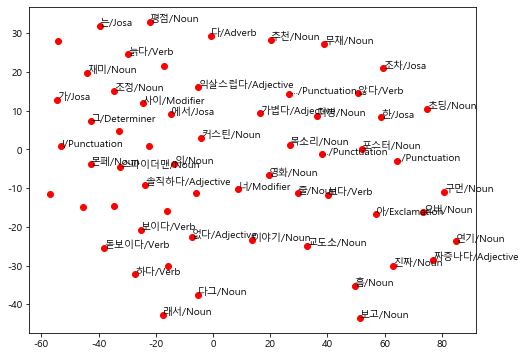

In [146]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize = (8, 6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c='red')


words = vocab[:50] 
for i, word in enumerate(words):
    plt.text(X_tsne[i,0], X_tsne[i,1 ], word, fontsize=10) 
plt.savefig('out.png', dpi=200)

### 3-2- 1. 두 유의어 그룹 간 유사도 시각화

C:\Users\student\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\student\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


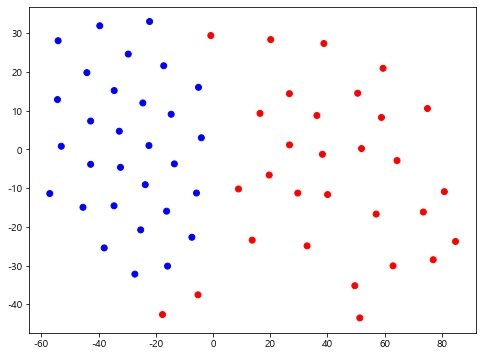

In [144]:
group1 = w2v_model.wv.most_similar(tokens('엄마'), topn = 30)
group1 = [w for (w, s) in group1]
X1 = w2v_model[group1]

group2 = w2v_model.wv.most_similar(tokens('정우성'), topn = 30)
group2 = [w for (w, s) in group2]
X2 = w2v_model[group2]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(np.vstack([X1, X2]))

label = np.hstack([(0 * np.ones(30)), np.ones(30)])

c = ['r' if l == 0 else 'b' for l in label ]

plt.figure(figsize = (8, 6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=c)

plt.savefig('out2.png', dpi=200)

## 부록) PCA 개념잡기

> 주성분분석(Principal Component Analysis)

> PCA는 데이터의 분산(variance)을 최대한 보존하면서 서로 직교하는 새 기저(축)를 찾아, 고차원 공간의 표본들을 선형 연관성이 없는 저차원 공간으로 변환하는 기법이다.

출처: https://ratsgo.github.io/machine%20learning/2017/04/24/PCA/

<img src=pca.gif>

# 4. RNN: Recurrent Neural Network

> 은닉층의 노드에서 활성화 함수를 통해 나온 결과값을 **출력층과 은닉층의 노드**에 다시 되먹이는 네트워크

> 데이터가 위로도 가고 옆으로도 간다.

<img src=rnn.jpg>

- 시계열 데이터 학습에 적합; 서로 인접한 데이터끼리 관련성이 있는 데이터


- y를 학습하는 것이 아니라, sequence 데이터로 학습한다.
    - y data(label data)가 따로 존재하지 않음


- 입력 데이터는 sequence 형으로 주어야 한다.
    - 숫자들의 sequence
    - 픽셀들의 sequence (즉 이미지)
    - 단어들의 sequence (즉 문장)
    - 사진들의 sequence (즉 동영상)

In [ ]:
seq = [1,2,3,4,5,6,7]
sp = 3

seq = [1,2,3,4,5,6,7,7,7,7]
#  3개의 seq 길이를 갖도록 학습 데이터 seq 생성
#  1,2,3,4,5,6,7,7,7,7                   [1,2,3]       [4] 
#                                        [2,3,4]       [5]   
#                                        [7,7,7]       [7] 

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer

from keras.preprocessing import sequence
from keras.preprocessing.sequence import  pad_sequences
from keras.datasets import imdb

from konlpy.tag import Okt
import statsmodels.api as sm
%matplotlib inline

Using TensorFlow backend.


In [148]:
model = Sequential()
model.add(SimpleRNN(3, input_shape=(2,10)))   #   input_length는 입력 시퀀스의 길이
# model.add(SimpleRNN(3, input_length=2, input_dim=10))와 동일함.
model.summary()
# 크기는 hidden 갯수와 dim에 의해 결정됨
# wx = 3 *  10  = 30      입력에서 hidden으로   
# wh = 3 * 3    = 9       출력이 hidden*hidden이므로   
# b = 3         = 3              -> 42개   # 출력층의 hidden

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 3)                 42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [149]:
step = 4
N = 1000    
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t)+2*np.random.rand(N)
df = pd.DataFrame(x)

values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]   # 800, 200개로 분할

print(train.shape)
print(test.shape)

(800, 1)
(200, 1)


In [150]:
train = np.append(train,np.repeat(train[-1,],step))  # 마지막값을 step만큼 반복
test = np.append(test,np.repeat(test[-1,],step))

In [151]:
print(train.shape)
print(test.shape)

(804,)
(204,)


In [152]:
print(train[:10])
print(train[798:])

[0.7964207  1.33947098 1.83210525 0.16723899 1.02107681 0.25402323
 1.76690613 0.98993064 1.78177734 0.58892316]
[0.52915629 0.55620213 0.55620213 0.55620213 0.55620213 0.55620213]


In [153]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):    #루프는 원래 데이터 크기만큼 돌아야 한다; len(data)는 원래 데이터 크기 + 패딩 4니까 step만큼 빼준다.
        d = i + step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

print(trainX.shape)
print(trainY.shape)

(800, 4)
(800,)


In [154]:
print(train[:10])
print(trainX[0])
print(trainX[1])
print(trainY[0])
print(trainY[1])

[0.7964207  1.33947098 1.83210525 0.16723899 1.02107681 0.25402323
 1.76690613 0.98993064 1.78177734 0.58892316]
[0.7964207  1.33947098 1.83210525 0.16723899]
[1.33947098 1.83210525 0.16723899 1.02107681]
1.0210768094947735
0.25402322607887123


In [155]:
#3차원 shape으로 구성
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

(800, 1, 4)


In [156]:
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="tanh"))
model.add(Dense(8, activation="tanh")) 
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=0)

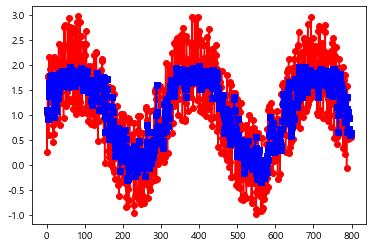

In [157]:
plt.plot(trainY, 'ro-', label="target")
plt.plot(model.predict(trainX), 'bs-', label="output")